## Store Pricing EDA Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

### 1. Data Loading and Preparation

In [2]:
# Define the path to your data file.
# You will need to change 'path/to/your/data.csv' to the actual location of your file.
data_path = 'store_pricing.csv'

# Load the dataset from the specified path.
# The 'low_memory=False' option is used to handle large files with mixed data types more efficiently.
df = pd.read_csv(data_path, low_memory=False)

In [3]:
# Define a list of columns that should contain numeric price-related data.
price_columns = [
    'live_price_1_amt', 'base_unit_price_amt', 'defined_reg_price_1_amt',
    'multi_save_price_amt', 'live_price_amt', 'defined_reg_price_amt',
    'upc_live_price_amt', 'upc_reg_price_amt', 'wm_wk_nbr'
]

# Loop through each column in the price_columns list.
for col in price_columns:
    # Check if the column exists in the DataFrame to avoid errors.
    if col in df.columns:
        # Convert the column to a numeric type.
        # 'errors='coerce'' will turn any values that cannot be converted into 'NaN' (Not a Number).
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create new derived columns for analysis if the required source columns exist.
if 'live_price_amt' in df.columns and 'defined_reg_price_amt' in df.columns:
    # Calculate the gap between the regular price and the live price.
    df['price_gap'] = df['defined_reg_price_amt'] - df['live_price_amt']
    
    # Calculate the discount percentage.
    # .fillna(0) replaces any NaN values (e.g., from division by zero) with 0.
    df['discount_pct'] = (df['price_gap'] / df['defined_reg_price_amt'] * 100).fillna(0)
    
# Create a boolean 'on_promotion' column based on the 'multi_save_ind' column.
if 'multi_save_ind' in df.columns:
    # If 'multi_save_ind' is 1, 'on_promotion' will be True, otherwise False.
    df['on_promotion'] = df['multi_save_ind'] == 1

### 2. Setup Analysis Variables

In [4]:
# Automatically identify all numeric columns in the DataFrame.
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Automatically identify all categorical (object/string) columns.
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Create a specific list of price-related columns for easier analysis.
# This list comprehension finds all numeric columns with 'price' or 'amt' in their name.
price_cols = [col for col in numeric_cols if 'price' in col.lower() or 'amt' in col.lower()]

# Define lists of key columns for geographic and time-based analysis.
geo_cols = ['prov_cd', 'region_nm', 'store_nbr']
time_col = 'wm_wk_nbr'

print("Data loaded and prepared successfully.")
print("\nFirst 5 rows of the DataFrame:")
df.head()

Data loaded and prepared successfully.

First 5 rows of the DataFrame:


,item_nbr,upc_nbr,old_nbr,store_nbr,prov_cd,region_nm,live_price_1_amt,base_unit_price_amt,defined_reg_price_1_amt,multi_save_price_amt,...,upc_reg_price_amt,crncy_cd,crncy_desc,geo_region_cd,op_cmpny_cd,upd_userid,wm_wk_nbr,price_gap,discount_pct,on_promotion
0,561412,62845119,31253,3109,BC,West,9.97,9.97,9.97,NaN,...,9.97,NaN,NaN,NaN,NaN,NaN,11833,0.0,0.0,False
1,561412,62845119,31253,3110,ON,Ontario,9.97,9.97,9.97,NaN,...,9.97,NaN,NaN,NaN,NaN,NaN,11833,0.0,0.0,False
2,561412,62845119,31253,3111,ON,Ontario,9.97,9.97,9.97,NaN,...,9.97,NaN,NaN,NaN,NaN,NaN,11833,0.0,0.0,False
3,561412,62845119,31253,3113,ON,Ontario,9.97,9.97,9.97,NaN,...,9.97,NaN,NaN,NaN,NaN,NaN,11833,0.0,0.0,False
4,561412,62845119,31253,3116,MB,West,9.97,9.97,9.97,NaN,...,9.97,NaN,NaN,NaN,NaN,NaN,11833,0.0,0.0,False


In [5]:
print("\nDataFrame Info:")
df.info()
print("\nKey Analysis Columns:")
print(f"Price Columns: {price_cols}")
print(f"Geo Columns: {geo_cols}")
print(f"Time Column: {time_col}")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   item_nbr                 10 non-null     int64  
 1   upc_nbr                  10 non-null     int64  
 2   old_nbr                  10 non-null     int64  
 3   store_nbr                10 non-null     int64  
 4   prov_cd                  10 non-null     object 
 5   region_nm                10 non-null     object 
 6   live_price_1_amt         10 non-null     float64
 7   base_unit_price_amt      10 non-null     float64
 8   defined_reg_price_1_amt  10 non-null     float64
 9   multi_save_price_amt     0 non-null      float64
 10  multi_save_ind           10 non-null     int64  
 11  live_price_amt           10 non-null     float64
 12  defined_reg_price_amt    10 non-null     float64
 13  upc_live_price_amt       10 non-null     float64
 14  upc_reg_pric

### Level 1: EDA Basic checks

#### 1.1 Data Structure Overview

In [6]:
print("="*60)
print("LEVEL 1: BASIC EDA ANALYSIS")
print("="*60)

# --- 1.1 Data Structure Overview ---
# This block provides a high-level summary of the dataset's structure.
# It prints the number of rows and columns, memory usage, and the count of
# unique items, stores, weeks, and provinces to understand the scale of the data.
# It also shows the time range covered and a summary of data types.
print("\n📋 1.1 DATA STRUCTURE OVERVIEW")
print("-" * 40)

print(f"Dataset Dimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

unique_products = df['item_nbr'].nunique() if 'item_nbr' in df.columns else 0
unique_stores = df['store_nbr'].nunique() if 'store_nbr' in df.columns else 0
unique_weeks = df['wm_wk_nbr'].nunique() if 'wm_wk_nbr' in df.columns else 0
unique_provinces = df['prov_cd'].nunique() if 'prov_cd' in df.columns else 0

print(f"\nKey Dimensions:")
print(f"  Unique Products: {unique_products:,}")
print(f"  Unique Stores: {unique_stores:,}")
print(f"  Unique Weeks: {unique_weeks}")
print(f"  Unique Provinces: {unique_provinces}")

if 'wm_wk_nbr' in df.columns:
    week_range = f"{df['wm_wk_nbr'].min()} to {df['wm_wk_nbr'].max()}"
    print(f"  Week Range: {week_range}")
    
print(f"\nData Types:")
print(df.dtypes.value_counts())

LEVEL 1: BASIC EDA ANALYSIS

📋 1.1 DATA STRUCTURE OVERVIEW
----------------------------------------
Dataset Dimensions: 10 rows × 24 columns
Memory Usage: 0.00 MB

Key Dimensions:
  Unique Products: 1
  Unique Stores: 10
  Unique Weeks: 1
  Unique Provinces: 4
  Week Range: 11833 to 11833

Data Types:
float64    15
int64       6
object      2
bool        1
Name: count, dtype: int64


#### 1.2 Geographic Coverage Analysis

In [7]:
# --- 1.2 Geographic Coverage Analysis ---
# This block examines the geographic distribution of the data.
# It calculates and prints the number of records for each province and region,
# as well as the number of unique stores within each province. This helps
# identify any geographic biases or areas with more or less data.
print("\n🗺️ 1.2 GEOGRAPHIC COVERAGE")
print("-" * 40)

if 'prov_cd' in df.columns:
    province_summary = df['prov_cd'].value_counts()
    print("Province Distribution:")
    print(province_summary)
    
if 'region_nm' in df.columns:
    region_summary = df['region_nm'].value_counts()
    print("\nRegion Distribution:")
    print(region_summary)
    
if 'store_nbr' in df.columns and 'prov_cd' in df.columns:
    stores_by_province = df.groupby('prov_cd')['store_nbr'].nunique()
    print("\nStores by Province:")
    print(stores_by_province)


🗺️ 1.2 GEOGRAPHIC COVERAGE
----------------------------------------
Province Distribution:
prov_cd
ON    7
BC    1
MB    1
XM    1
Name: count, dtype: int64

Region Distribution:
region_nm
Ontario     7
West        2
Atlantic    1
Name: count, dtype: int64

Stores by Province:
prov_cd
BC    1
MB    1
ON    7
XM    1
Name: store_nbr, dtype: int64


#### 1.3 Basic Pricing Overview

In [15]:
# --- 1.3 Basic Pricing Overview ---
# This block provides a summary of the key pricing variables.
# It generates descriptive statistics (count, mean, std, min, max, etc.) for all price-related columns.
# It also calculates the overall promotional rate and summarizes the distribution
# of the 'price_gap' (regular price vs. live price).
print("\n💰 1.3 BASIC PRICING OVERVIEW")
print("-" * 40)

if price_cols:
    print("Price Variable Summary:")
    price_summary = df[price_cols].describe()
    print(price_summary.round(2))
    
if 'on_promotion' in df.columns:
    promo_rate = df['on_promotion'].mean() * 100
    print(f"\nPromotional Activity:")
    print(f"  Products on promotion: {promo_rate:.1f}%")
    
if 'price_gap' in df.columns:
    gap_stats = df['price_gap'].describe()
    print(f"\nPrice Gap Statistics (Regular - Live):")
    print(gap_stats.round(2))


💰 1.3 BASIC PRICING OVERVIEW
----------------------------------------
Price Variable Summary:
       live_price_1_amt  base_unit_price_amt  defined_reg_price_1_amt  \
count             10.00                10.00                    10.00   
mean               9.97                 9.97                     9.97   
std                0.00                 0.00                     0.00   
min                9.97                 9.97                     9.97   
25%                9.97                 9.97                     9.97   
50%                9.97                 9.97                     9.97   
75%                9.97                 9.97                     9.97   
max                9.97                 9.97                     9.97   

       multi_save_price_amt  live_price_amt  defined_reg_price_amt  \
count                   0.0           10.00                  10.00   
mean                    NaN            9.97                   9.97   
std                     NaN          

#### 1.4 Data Quality Assessment

In [16]:
# --- 1.4 Data Quality Assessment ---
# This block performs essential data quality checks.
# It identifies and reports the count and percentage of missing values for each column.
# It also checks for common data issues like negative or zero prices and counts
# the number of duplicate rows in the dataset.
print("\n🛡️ 1.4 DATA QUALITY CHECKS")
print("-" * 40)

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
print("Missing Data Summary:")
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Percentage', ascending=False)
print(missing_df[missing_df.Missing_Count > 0].head(10))

print("\nData Quality Issues:")
for col in price_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"  Negative values in {col}: {negative_count}")
            
for col in price_cols:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        if zero_count > 0:
            print(f"  Zero values in {col}: {zero_count}")
            
duplicates = df.duplicated().sum()
print(f"  Duplicate rows: {duplicates}")


🛡️ 1.4 DATA QUALITY CHECKS
----------------------------------------
Missing Data Summary:
                      Missing_Count  Missing_Percentage
upd_userid                       10               100.0
op_cmpny_cd                      10               100.0
geo_region_cd                    10               100.0
crncy_desc                       10               100.0
multi_save_price_amt             10               100.0
crncy_cd                         10               100.0

Data Quality Issues:
  Zero values in price_gap: 10
  Duplicate rows: 0


#### 1.5 Basic Visualizations


📈 1.5 BASIC VISUALIZATIONS
----------------------------------------


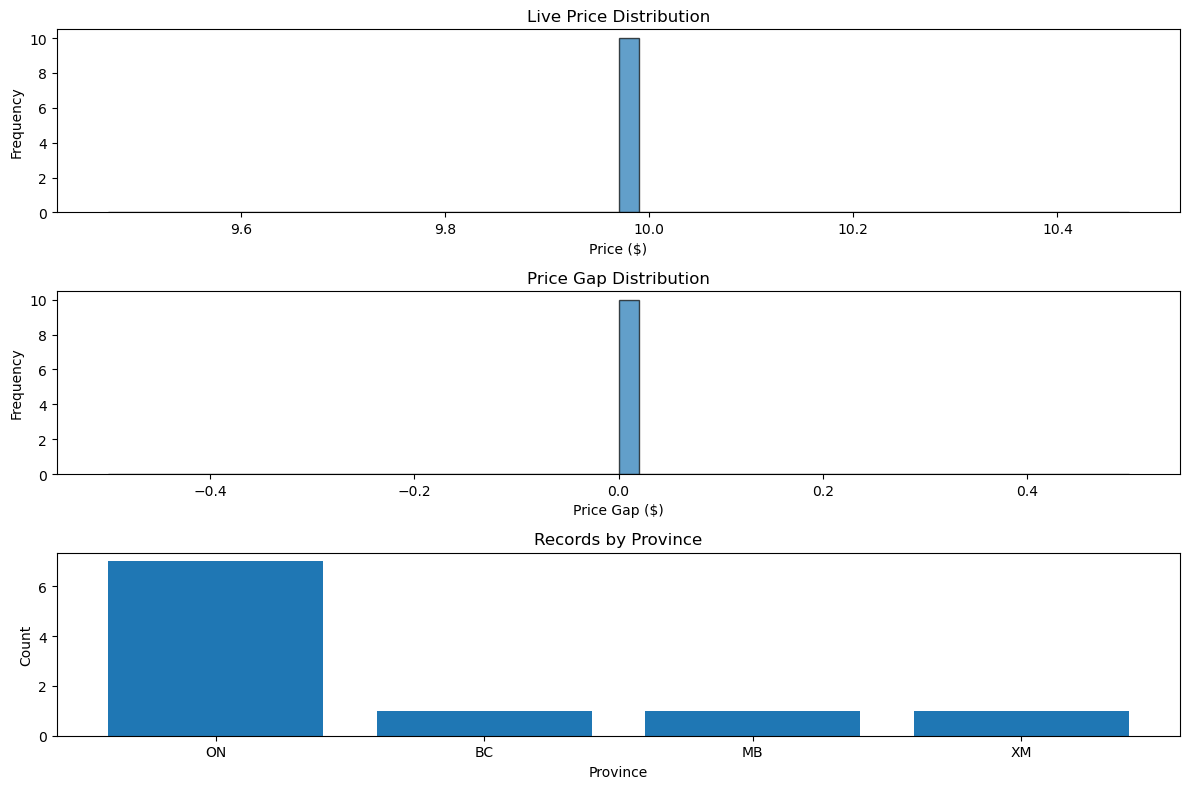


✅ LEVEL 1 BASIC ANALYSIS COMPLETED


In [17]:
# --- 1.5 Basic Visualizations ---
# This block generates a few simple plots to visually inspect the data.
# It creates histograms for the 'live_price_amt' and 'price_gap' to show their
# distributions, and a bar chart to visualize the number of records per province.
# These plots provide a quick visual understanding of key variables.
print("\n📈 1.5 BASIC VISUALIZATIONS")
print("-" * 40)

if 'live_price_amt' in df.columns:
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Live Price Distribution
    plt.subplot(3, 1, 1)
    live_prices = df['live_price_amt'].dropna()
    plt.hist(live_prices, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Live Price Distribution')
    plt.xlabel('Price ($)')
    plt.ylabel('Frequency')
    
    # Plot 2: Price Gap Distribution
    if 'price_gap' in df.columns:
        plt.subplot(3, 1, 2)
        price_gaps = df['price_gap'].dropna()
        plt.hist(price_gaps, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Price Gap Distribution')
        plt.xlabel('Price Gap ($)')
        plt.ylabel('Frequency')
        
    # Plot 3: Records by Province
    if 'prov_cd' in df.columns:
        plt.subplot(3, 1, 3)
        province_counts = df['prov_cd'].value_counts()
        plt.bar(province_counts.index, province_counts.values)
        plt.title('Records by Province')
        plt.xlabel('Province')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
    plt.tight_layout()
    plt.show()

print("\n✅ LEVEL 1 BASIC ANALYSIS COMPLETED")

### Level 2: EDA Medium Analysis

#### 2.1 Geographic Price Analysis


🗺️ 2.1 GEOGRAPHIC PRICE ANALYSIS
----------------------------------------
Provincial Price Analysis:
        live_price_amt                   price_gap on_promotion
                  mean median  std count      mean         mean
prov_cd                                                        
BC                9.97   9.97  NaN     1       0.0          0.0
MB                9.97   9.97  NaN     1       0.0          0.0
ON                9.97   9.97  0.0     7       0.0          0.0
XM                9.97   9.97  NaN     1       0.0          0.0

ANOVA Test for Provincial Price Differences:
  F-statistic: nan
  P-value: nan
  Significant difference: No


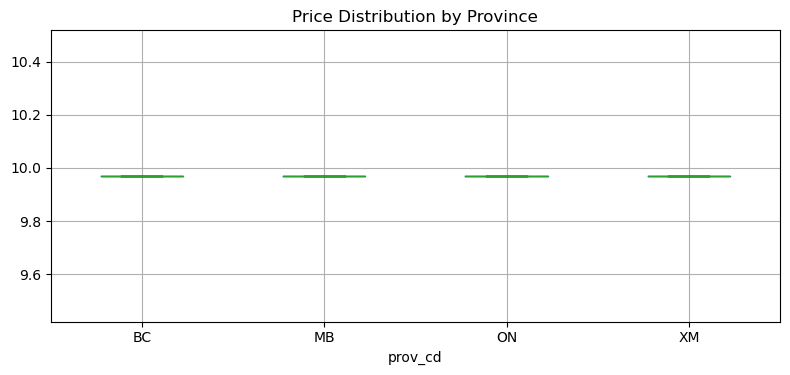

In [18]:
# 2.1 Geographic Price Analysis
print("\n🗺️ 2.1 GEOGRAPHIC PRICE ANALYSIS")
print("-" * 40)

if all(col in df.columns for col in ['prov_cd', 'live_price_amt']):
    # Provincial analysis
    provincial_stats_agg = {
        'live_price_amt': ['mean', 'median', 'std', 'count']
    }
    if 'price_gap' in df.columns:
        provincial_stats_agg['price_gap'] = 'mean'
    if 'on_promotion' in df.columns:
        provincial_stats_agg['on_promotion'] = 'mean'
        
    provincial_stats = df.groupby('prov_cd').agg(provincial_stats_agg).round(2)
    
    print("Provincial Price Analysis:")
    print(provincial_stats)
    
    # Statistical test for provincial differences
    provinces = df['prov_cd'].unique()
    if len(provinces) > 1:
        province_groups = [df[df['prov_cd'] == prov]['live_price_amt'].dropna() 
                         for prov in provinces]
        
        if all(len(group) > 0 for group in province_groups):
            f_stat, p_value = stats.f_oneway(*province_groups)
            print(f"\nANOVA Test for Provincial Price Differences:")
            print(f"  F-statistic: {f_stat:.3f}")
            print(f"  P-value: {p_value:.3f}")
            print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
            
    # Box plot by province
    plt.figure(figsize=(8, 4))
    df.boxplot(column='live_price_amt', by='prov_cd', ax=plt.gca())
    plt.title('Price Distribution by Province')
    plt.suptitle('')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

#### 2.2 Temporal Price Analysis


⏰ 2.2 TEMPORAL PRICE ANALYSIS
----------------------------------------
Weekly Trends (first 10 weeks):
          live_price_amt            price_gap on_promotion
                    mean  std count      mean         mean
wm_wk_nbr                                                 
11833               9.97  0.0    10       0.0          0.0


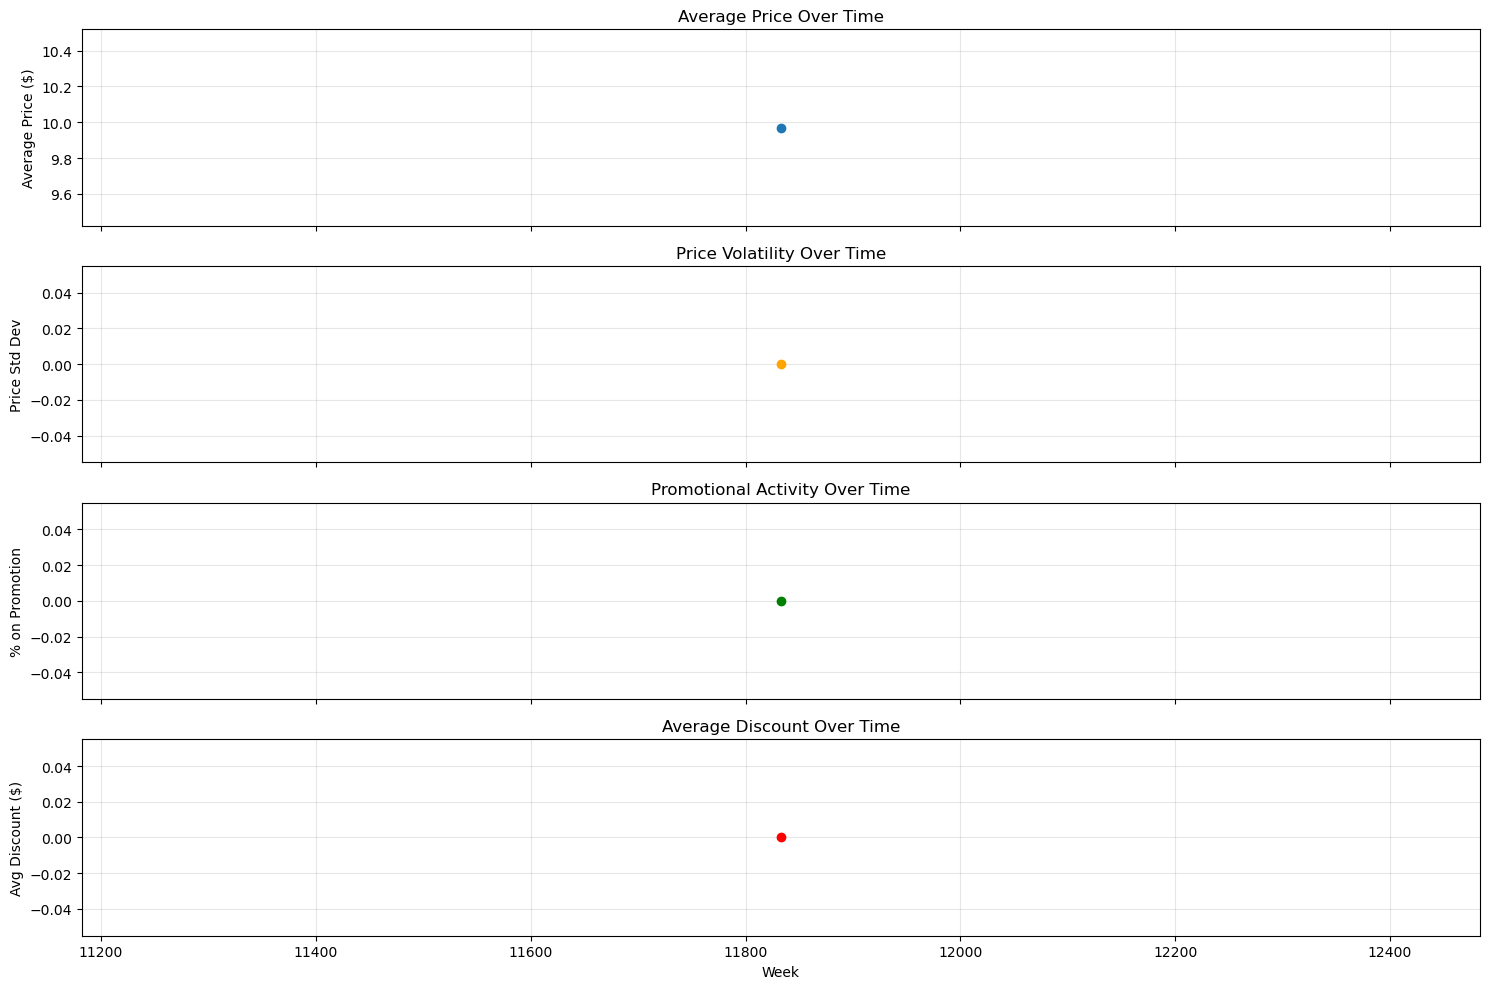

In [19]:
# 2.2 Temporal Price Analysis
print("\n⏰ 2.2 TEMPORAL PRICE ANALYSIS")
print("-" * 40)

if all(col in df.columns for col in ['wm_wk_nbr', 'live_price_amt']):
    # Weekly aggregation
    weekly_stats_agg = {
        'live_price_amt': ['mean', 'std', 'count']
    }
    if 'price_gap' in df.columns:
        weekly_stats_agg['price_gap'] = 'mean'
    if 'on_promotion' in df.columns:
        weekly_stats_agg['on_promotion'] = 'mean'
        
    weekly_stats = df.groupby('wm_wk_nbr').agg(weekly_stats_agg).round(2)
    
    print("Weekly Trends (first 10 weeks):")
    print(weekly_stats.head(10))
    
    # Time series visualization
    # fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Time series visualization - vertical layout
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    
    # Average price over time
    weekly_price = df.groupby('wm_wk_nbr')['live_price_amt'].mean()
    axes[0].plot(weekly_price.index, weekly_price.values, marker='o', linewidth=2)
    axes[0].set_title('Average Price Over Time')
    axes[0].set_ylabel('Average Price ($)')
    axes[0].grid(True, alpha=0.3)
    
    # Price volatility over time
    weekly_std = df.groupby('wm_wk_nbr')['live_price_amt'].std()
    axes[1].plot(weekly_std.index, weekly_std.values, marker='o', linewidth=2, color='orange')
    axes[1].set_title('Price Volatility Over Time')
    axes[1].set_ylabel('Price Std Dev')
    axes[1].grid(True, alpha=0.3)
    
    # Promotional activity over time
    if 'on_promotion' in df.columns:
        weekly_promo = df.groupby('wm_wk_nbr')['on_promotion'].mean() * 100
        axes[2].plot(weekly_promo.index, weekly_promo.values, marker='o', linewidth=2, color='green')
        axes[2].set_title('Promotional Activity Over Time')
        axes[2].set_ylabel('% on Promotion')
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].set_visible(False)  # Hide if not used
    
    # Average discount over time
    if 'price_gap' in df.columns:
        weekly_gap = df.groupby('wm_wk_nbr')['price_gap'].mean()
        axes[3].plot(weekly_gap.index, weekly_gap.values, marker='o', linewidth=2, color='red')
        axes[3].set_title('Average Discount Over Time')
        axes[3].set_xlabel('Week')
        axes[3].set_ylabel('Avg Discount ($)')
        axes[3].grid(True, alpha=0.3)
    else:
        axes[3].set_visible(False)  # Hide if not used
    
    plt.tight_layout()
    plt.show()

#### 2.3 Promotion Impact Analysis


🎉 2.3 PROMOTION IMPACT ANALYSIS
----------------------------------------
Promotion Summary:
  On Promotion: 0 obs (0.0%)
  Not on Promotion: 10 obs (100.0%)


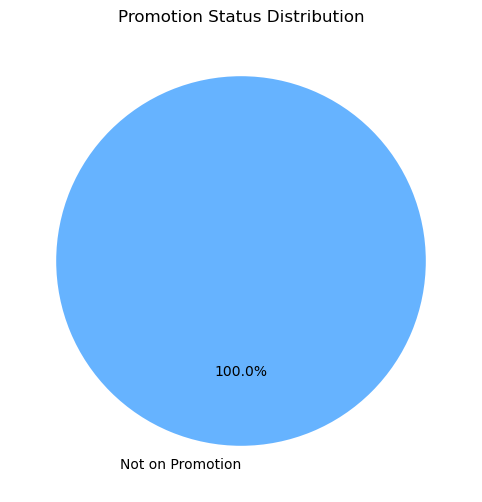

In [20]:
# 2.3 Promotion Impact Analysis
print("\n🎉 2.3 PROMOTION IMPACT ANALYSIS")
print("-" * 40)

if 'on_promotion' in df.columns:
    # Promotion summary
    promo_counts = df['on_promotion'].value_counts()
    promo_perc = df['on_promotion'].value_counts(normalize=True) * 100
    
    print("Promotion Summary:")
    print(f"  On Promotion: {promo_counts.get(True, 0)} obs ({promo_perc.get(True, 0):.1f}%)")
    print(f"  Not on Promotion: {promo_counts.get(False, 0)} obs ({promo_perc.get(False, 0):.1f}%)")

    # --- PLOT 1: Promotion Status Pie Chart ---
    plt.figure(figsize=(8, 6))
    
    # Dynamically generate labels and colors to prevent ValueError
    labels = []
    colors = []
    for status in promo_counts.index:
        if status:
            labels.append('On Promotion')
            colors.append('#ff9999')
        else:
            labels.append('Not on Promotion')
            colors.append('#66b3ff')

    plt.pie(promo_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Promotion Status Distribution')
    plt.ylabel('') # Hides the 'on_promotion' label on the y-axis
    plt.show()


Weekly Promotion Rates:
  Highest promotion week: 11833 (0.0%)
  Lowest promotion week: 11833 (0.0%)
  Average weekly variation: nan%


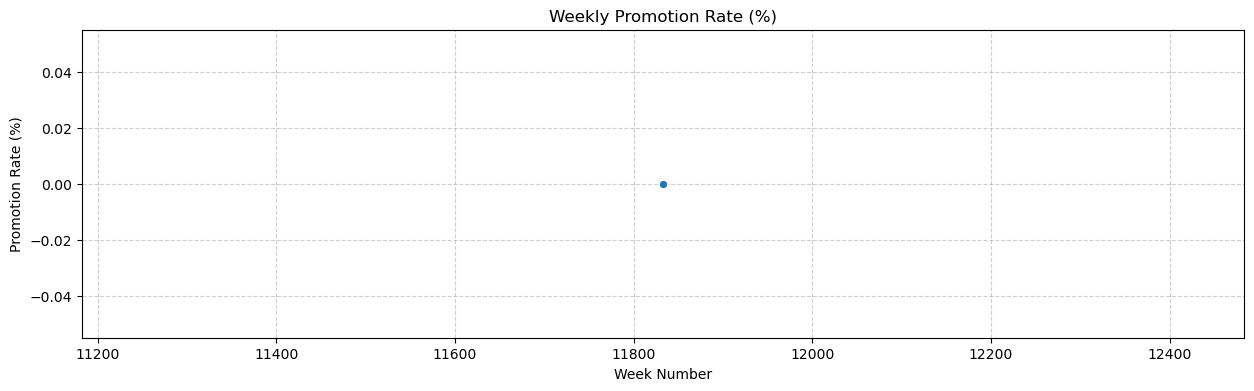

In [21]:
# Weekly promotion analysis
if 'wm_wk_nbr' in df.columns:
    weekly_promo = df.groupby('wm_wk_nbr')['on_promotion'].mean() * 100
    print(f"\nWeekly Promotion Rates:")
    print(f"  Highest promotion week: {weekly_promo.idxmax()} ({weekly_promo.max():.1f}%)")
    print(f"  Lowest promotion week: {weekly_promo.idxmin()} ({weekly_promo.min():.1f}%)")
    print(f"  Average weekly variation: {weekly_promo.std():.1f}%")

    # --- PLOT 2: Weekly Promotion Rate Line Plot ---
    plt.figure(figsize=(15, 4))
    sns.lineplot(x=weekly_promo.index, y=weekly_promo.values, marker='o')
    plt.title('Weekly Promotion Rate (%)')
    plt.xlabel('Week Number')
    plt.ylabel('Promotion Rate (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Discount Analysis:
  Average discount when on promotion: $nan
  Average gap when not on promotion: $0.00


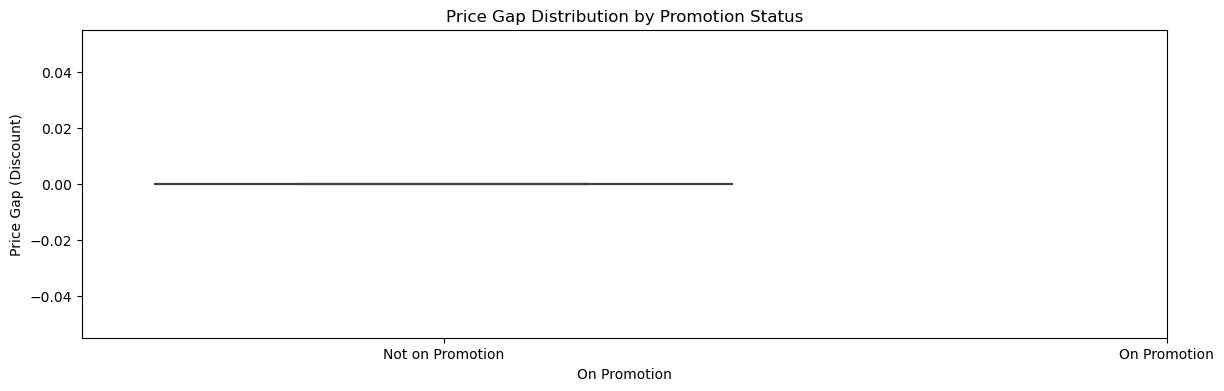

In [22]:
# Discount analysis
if 'price_gap' in df.columns and 'on_promotion' in df.columns:
    promo_discounts = df[df['on_promotion']]['price_gap']
    non_promo_gaps = df[~df['on_promotion']]['price_gap']
    
    print(f"\nDiscount Analysis:")
    print(f"  Average discount when on promotion: ${promo_discounts.mean():.2f}")
    print(f"  Average gap when not on promotion: ${non_promo_gaps.mean():.2f}")
    
    # --- PLOT 3: Discount Distribution Box Plot ---
    plt.figure(figsize=(14, 4))
    sns.boxplot(x='on_promotion', y='price_gap', data=df)
    plt.title('Price Gap Distribution by Promotion Status')
    plt.xlabel('On Promotion')
    plt.ylabel('Price Gap (Discount)')
    plt.xticks([False, True], ['Not on Promotion', 'On Promotion'])
    plt.show()

    # Statistical test
    if len(promo_discounts) > 10 and len(non_promo_gaps) > 10:
        # Drop NaN values for the statistical test
        clean_promo_discounts = promo_discounts.dropna()
        clean_non_promo_gaps = non_promo_gaps.dropna()
        if len(clean_promo_discounts) > 1 and len(clean_non_promo_gaps) > 1:
            t_stat, p_value = stats.ttest_ind(clean_promo_discounts, clean_non_promo_gaps, equal_var=False) # Welch's t-test
            print(f"\n  Statistical difference in price gaps: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.3f})")

#### 2.4 Store Performance Analysis


🏪 2.4 STORE PERFORMANCE ANALYSIS
----------------------------------------
Store Performance Summary (top 10 by unique item count):


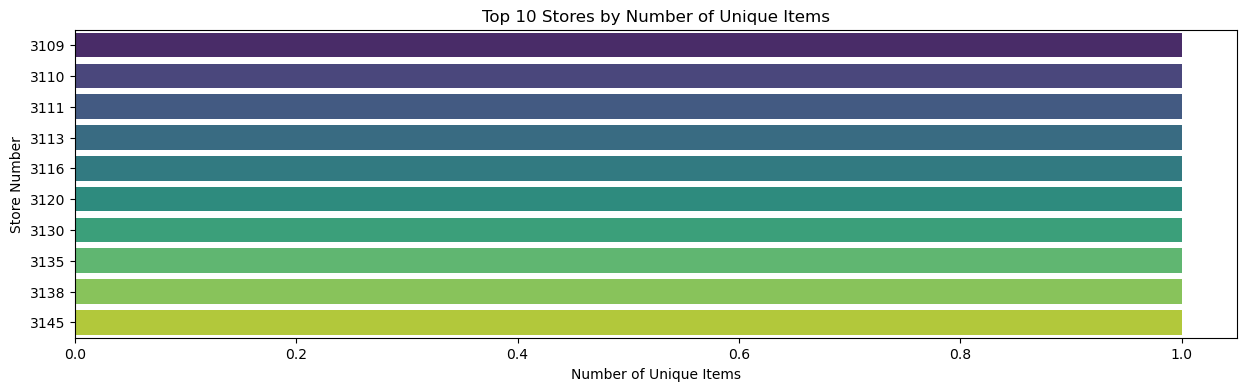


Store Price Ranking:


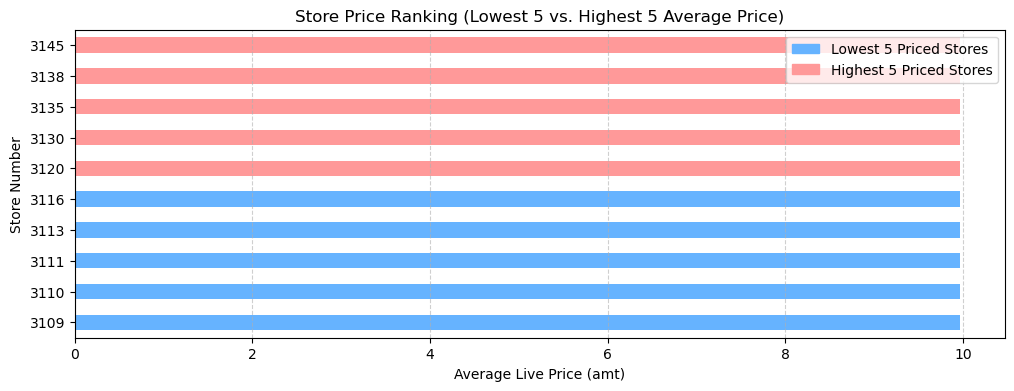


Store Price Consistency (lowest volatility = most consistent, top 5):
store_nbr
3109   NaN
3110   NaN
3111   NaN
3113   NaN
3116   NaN
Name: live_price_amt, dtype: float64


In [23]:
# 2.4 Store Performance Analysis
print("\n🏪 2.4 STORE PERFORMANCE ANALYSIS")
print("-" * 40)

# Configuration for the number of stores to display in summaries and plots
# This helps manage visualizations when there are a large number of stores.
num_top_stores_to_show = 10
num_ranking_stores_to_show = 5

# --- CONFIGURATION ---
item_column = 'item_nbr'

if 'store_nbr' in df.columns and 'live_price_amt' in df.columns and item_column in df.columns:
    # Store-level analysis based on unique item count
    store_stats_agg = {
        'live_price_amt': ['mean', 'std'],
        item_column: ['nunique']  # Count unique items per store
    }
    if 'price_gap' in df.columns:
        store_stats_agg['price_gap'] = 'mean'
    if 'on_promotion' in df.columns:
        store_stats_agg['on_promotion'] = 'mean'
        
    store_stats = df.groupby('store_nbr').agg(store_stats_agg).round(2)
    
    # Flatten column names for easier access
    store_stats.columns = ['_'.join(col).strip() for col in store_stats.columns]
    item_count_col = f'{item_column}_nunique'
    
    print(f"Store Performance Summary (top {num_top_stores_to_show} by unique item count):")
    top_stores = store_stats.nlargest(num_top_stores_to_show, item_count_col)
    #print(top_stores)
    
    # --- PLOT 4: Top Stores by Unique Item Count ---
    plt.figure(figsize=(15, 4))
    sns.barplot(x=item_count_col, y=top_stores.index.astype(str), data=top_stores, orient='h', palette='viridis')
    plt.title(f'Top {num_top_stores_to_show} Stores by Number of Unique Items')
    plt.xlabel('Number of Unique Items')
    plt.ylabel('Store Number')
    plt.show()

    # Store price ranking (remains the same)
    avg_prices = df.groupby('store_nbr')['live_price_amt'].mean().sort_values()
    
    print(f"\nStore Price Ranking:")
    
    # --- PLOT 5: Store Price Ranking ---
    if len(avg_prices) >= num_ranking_stores_to_show * 2:
        plot_data = pd.concat([avg_prices.head(num_ranking_stores_to_show), avg_prices.tail(num_ranking_stores_to_show)])
        colors = ['#66b3ff'] * num_ranking_stores_to_show + ['#ff9999'] * num_ranking_stores_to_show
        
        plt.figure(figsize=(12, 4))
        plot_data.plot(kind='barh', color=colors)
        
        plt.title(f'Store Price Ranking (Lowest {num_ranking_stores_to_show} vs. Highest {num_ranking_stores_to_show} Average Price)')
        plt.xlabel('Average Live Price (amt)')
        plt.ylabel('Store Number')
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        
        # Create legend
        lowest_patch = mpatches.Patch(color='#66b3ff', label=f'Lowest {num_ranking_stores_to_show} Priced Stores')
        highest_patch = mpatches.Patch(color='#ff9999', label=f'Highest {num_ranking_stores_to_show} Priced Stores')
        plt.legend(handles=[lowest_patch, highest_patch])
        
        plt.show()
    else:
        print("\nSkipping price ranking plot as there are not enough stores to compare.")

    # Store consistency analysis (remains the same)
    store_volatility = df.groupby('store_nbr')['live_price_amt'].std().sort_values()
    print(f"\nStore Price Consistency (lowest volatility = most consistent, top {num_ranking_stores_to_show}):")
    print(store_volatility.head(num_ranking_stores_to_show).round(2))
else:
    print(f"Could not perform store analysis. Required columns ('store_nbr', 'live_price_amt', '{item_column}') not found in the DataFrame.")

#### 2.5 Statistical Relationship Analysis


📊 2.5 STATISTICAL RELATIONSHIPS
----------------------------------------


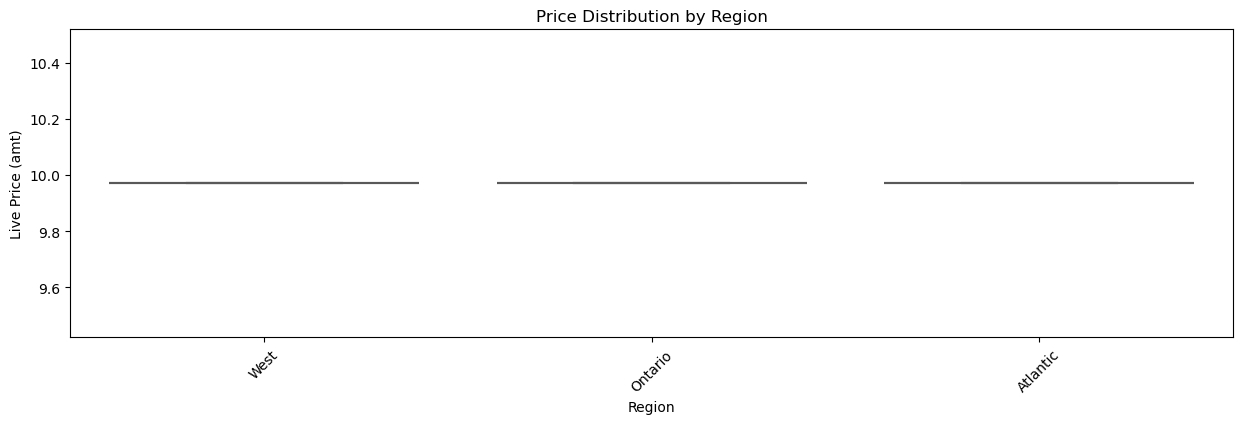


Regional Price Differences (ANOVA):
  F-statistic: nan
  P-value: nan
  Significant regional differences: No

✅ LEVEL 2 MEDIUM ANALYSIS COMPLETED


In [26]:
# 2.5 Statistical Relationship Analysis
print("\n📊 2.5 STATISTICAL RELATIONSHIPS")
print("-" * 40)
            
# Regional price differences
if all(col in df.columns for col in ['region_nm', 'live_price_amt']):
    regions = df['region_nm'].unique()
    if len(regions) > 1:
        # --- PLOT 6: Regional Price Distribution Boxplot ---
        plt.figure(figsize=(15, 4))
        sns.boxplot(x='region_nm', y='live_price_amt', data=df, palette='Set2')
        plt.title('Price Distribution by Region')
        plt.xlabel('Region')
        plt.ylabel('Live Price (amt)')
        plt.xticks(rotation=45)
        plt.show()

        region_groups = [df[df['region_nm'] == region]['live_price_amt'].dropna() 
                       for region in regions]
        
        if all(len(group) > 0 for group in region_groups):
            f_stat, p_value = stats.f_oneway(*region_groups)
            print(f"\nRegional Price Differences (ANOVA):")
            print(f"  F-statistic: {f_stat:.3f}")
            print(f"  P-value: {p_value:.3f}")
            print(f"  Significant regional differences: {'Yes' if p_value < 0.05 else 'No'}")

print("\n✅ LEVEL 2 MEDIUM ANALYSIS COMPLETED")

In [30]:
# Correlation analysis

# --- Start of Debugging Code ---
# Check if price_cols exists and what it contains
if 'price_cols' in locals():
    print(f"✅ 'price_cols' is defined.")
    print(f"   Content: {price_cols}")
    print(f"   Number of columns: {len(price_cols)}")
else:
    print(f"❌ 'price_cols' is not defined. Please define it as a list of column names.")
# --- End of Debugging Code ---


if 'price_cols' in locals() and len(price_cols) > 1:
    price_data = df[price_cols].dropna()
    
    # --- Start of Debugging Code ---
    # Check how many rows are left after dropping missing values
    print(f"   Number of rows in price_data (after dropna): {len(price_data)}")
    # --- End of Debugging Code ---

    if len(price_data) > 50:
        print("✅ Conditions met. Generating plot...")
        correlation_matrix = price_data.corr()
        
        plt.figure(figsize=(15, 5))
        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5)
        plt.title('Price Variables Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        # Strong correlations
        print("Strong correlations (|r| > 0.7):")
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    print(f"  {correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: {corr_val:.3f}")
    else:
        print("❌ Plotting skipped: Not enough data (50 or fewer rows) after removing missing values.")
else:
    print("❌ Plotting skipped: 'price_cols' is not defined or has fewer than 2 columns.")

✅ 'price_cols' is defined.
   Content: ['live_price_1_amt', 'base_unit_price_amt', 'defined_reg_price_1_amt', 'multi_save_price_amt', 'live_price_amt', 'defined_reg_price_amt', 'upc_live_price_amt', 'upc_reg_price_amt', 'price_gap']
   Number of columns: 9
   Number of rows in price_data (after dropna): 0
❌ Plotting skipped: Not enough data (50 or fewer rows) after removing missing values.


#### 2.5 Statistical Relationship Analysis


📊 2.5 STATISTICAL RELATIONSHIPS
----------------------------------------


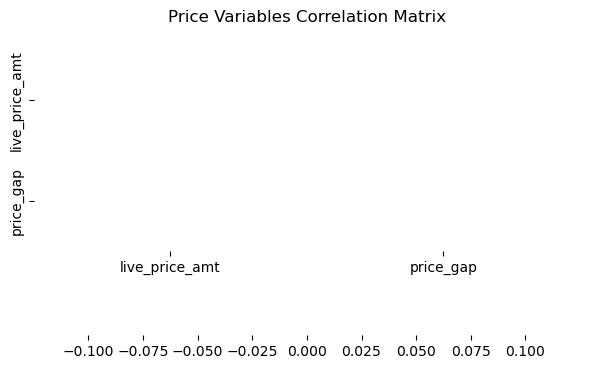

Strong correlations (|r| > 0.7):


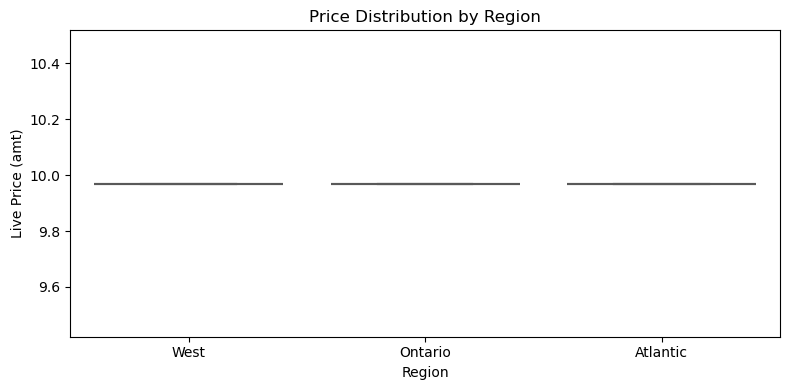


Regional Price Differences (ANOVA):
  F-statistic: nan
  P-value: nan
  Significant regional differences: No

✅ LEVEL 2 MEDIUM ANALYSIS COMPLETED


In [32]:
# 2.5 Statistical Relationship Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("\n📊 2.5 STATISTICAL RELATIONSHIPS")
print("-" * 40)

# Define the price-related columns available in the current DataFrame
price_cols = ['live_price_amt', 'price_gap']

# Correlation analysis
if len(price_cols) > 1:
    price_data = df[price_cols].dropna()
    
    if len(price_data) > 1:
        correlation_matrix = price_data.corr()
        
        # --- FIXED CORRELATION PLOT ---
        plt.figure(figsize=(6, 4))  # Adjusted size
        sns.heatmap(
            correlation_matrix,
            annot=True,
            cmap='RdBu_r',
            center=0,
            linewidths=0.5,
            cbar_kws={"orientation": "horizontal", "shrink": 0.8, "pad": 0.2}  # Horizontal colorbar
        )
        plt.title('Price Variables Correlation Matrix', pad=20)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()
        
        # Strong correlations
        print("Strong correlations (|r| > 0.7):")
        if not correlation_matrix.empty:
            for i in range(len(correlation_matrix.columns)):
                for j in range(i + 1, len(correlation_matrix.columns)):
                    corr_val = correlation_matrix.iloc[i, j]
                    if abs(corr_val) > 0.7:
                        print(f"  {correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: {corr_val:.3f}")
    else:
        print("Not enough data to compute a correlation matrix for price variables.")
        
# Regional price differences
if all(col in df.columns for col in ['region_nm', 'live_price_amt']):
    regions = df['region_nm'].unique()
    if len(regions) > 1:
        # --- PLOT 6: Regional Price Distribution Boxplot ---
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='region_nm', y='live_price_amt', data=df, palette='Set2')
        plt.title('Price Distribution by Region')
        plt.xlabel('Region')
        plt.ylabel('Live Price (amt)')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

        region_groups = [df[df['region_nm'] == region]['live_price_amt'].dropna() 
                         for region in regions]
        
        if all(len(group) > 0 for group in region_groups):
            f_stat, p_value = stats.f_oneway(*region_groups)
            print(f"\nRegional Price Differences (ANOVA):")
            print(f"  F-statistic: {f_stat:.3f}")
            print(f"  P-value: {p_value:.3f}")
            print(f"  Significant regional differences: {'Yes' if p_value < 0.05 else 'No'}")
else:
    print("\nSkipping regional price analysis: 'region_nm' column not found in DataFrame.")

print("\n✅ LEVEL 2 MEDIUM ANALYSIS COMPLETED")


### Level 3: EDA Analysis

#### 3.1 Store Clustering Analysis

In [35]:
print("\n🎯 3.1 STORE CLUSTERING ANALYSIS")
print("-" * 40)

if 'store_nbr' in df.columns and len(price_cols) > 0:
    # Create store-level features
    agg_dict = {
        'live_price_amt': ['mean', 'std'],
    }
    if 'price_gap' in df.columns:
        agg_dict['price_gap'] = 'mean'
    if 'on_promotion' in df.columns:
        agg_dict['on_promotion'] = 'mean'
    
    store_features = df.groupby('store_nbr').agg(agg_dict).round(3)
    
    # Flatten column names
    store_features.columns = ['_'.join(col).strip() for col in store_features.columns]
    store_features = store_features.dropna()
    
    if len(store_features) > 10:
        # Standardize features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(store_features)
        
        # K-means clustering
        n_clusters = min(5, len(store_features) // 3)  # Reasonable number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(scaled_features)
        
        # Add clusters back to store features
        store_features['cluster'] = clusters
        store_features
        
        print(f"Store Clustering Results ({n_clusters} clusters):")
        cluster_summary = store_features.groupby('cluster').agg({
            c: 'mean' for c in store_features.columns if c != 'cluster'
        })
        cluster_summary['Num_Stores'] = store_features['cluster'].value_counts()
        print(cluster_summary.round(2))
        
        # PCA for visualization
        if scaled_features.shape[1] > 2:
            pca = PCA(n_components=2)
            pca_features = pca.fit_transform(scaled_features)
            
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                                c=clusters, cmap='viridis', alpha=0.7, s=60)
            plt.colorbar(scatter, label='Cluster')
            plt.title('Store Clustering Visualization (PCA Space)')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"PCA Variance Explained: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")


🎯 3.1 STORE CLUSTERING ANALYSIS
----------------------------------------


#### 3.2 Advanced Temporal Pattern Analysis

In [36]:
# 3.2 Advanced Temporal Pattern Analysis
# ----------------------------------------
print("\n⏰ 3.2 ADVANCED TEMPORAL PATTERNS")
print("-" * 40)

if all(col in df.columns for col in ['wm_wk_nbr', 'live_price_amt']):
    weekly_data = df.groupby('wm_wk_nbr')['live_price_amt'].mean()
    
    if len(weekly_data) >= 20:  # Need sufficient data for pattern analysis
        # Trend analysis
        weeks = np.arange(len(weekly_data))
        trend_coef = np.polyfit(weeks, weekly_data.values, 1)[0]
        print(f"Overall price trend: ${trend_coef:.4f} per week")
        
        # Seasonality detection (if full year available)
        if len(weekly_data) >= 52:
            # Simple seasonal decomposition
            weekly_df = weekly_data.reset_index()
            weekly_df['week_of_year'] = weekly_df['wm_wk_nbr'] % 52
            seasonal_pattern = weekly_df.groupby('week_of_year')['live_price_amt'].mean()
            
            # Seasonal strength
            seasonal_var = seasonal_pattern.var()
            total_var = weekly_data.var()
            seasonal_strength = seasonal_var / total_var
            
            print(f"Seasonal strength: {seasonal_strength:.3f} ({seasonal_strength*100:.1f}% of total variation)")
            
            # Plot seasonal pattern
            plt.figure(figsize=(15, 6))
            
            plt.subplot(1, 2, 1)
            plt.plot(weekly_data.index, weekly_data.values, linewidth=2)
            plt.title('Weekly Price Time Series')
            plt.xlabel('Week Number')
            plt.ylabel('Average Price ($)')
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.plot(seasonal_pattern.index, seasonal_pattern.values, marker='o', linewidth=2)
            plt.title('Seasonal Pattern (52-week cycle)')
            plt.xlabel('Week of Year')
            plt.ylabel('Average Price ($)')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        # Price volatility analysis
        price_changes = weekly_data.pct_change().dropna()
        
        # Find high volatility periods (changes > 2 std deviations)
        threshold = price_changes.std() * 2
        high_vol_weeks = price_changes[abs(price_changes) > threshold]
        
        if len(high_vol_weeks) > 0:
            print(f"\nHigh Volatility Periods:")
            print(f"  Number of volatile weeks: {len(high_vol_weeks)}")
            print(f"  Average change in volatile weeks: {high_vol_weeks.mean()*100:.1f}%")
            most_volatile_week = high_vol_weeks.abs().idxmax()
            print(f"  Most volatile week: {most_volatile_week} ({high_vol_weeks[most_volatile_week]*100:.1f}% change)")



⏰ 3.2 ADVANCED TEMPORAL PATTERNS
----------------------------------------


#### 3.3 Advanced Geographic Analysis

In [37]:
print("\n🗺️ 3.3 ADVANCED GEOGRAPHIC ANALYSIS")
print("-" * 40)

if all(col in df.columns for col in ['prov_cd', 'store_nbr', 'live_price_amt']):
    # Price coordination within provinces
    coordination_analysis = {}
    
    for province in df['prov_cd'].unique():
        prov_data = df[df['prov_cd'] == province]
        
        if len(prov_data['store_nbr'].unique()) > 1:
            # Calculate price correlation between stores in same province
            store_pivot = prov_data.pivot_table(
                index='wm_wk_nbr', 
                columns='store_nbr', 
                values='live_price_amt'
            )
            
            if store_pivot.shape[1] > 1:
                correlations = store_pivot.corr()
                avg_correlation = correlations.values[np.triu_indices_from(correlations.values, k=1)].mean()
                coordination_analysis[province] = avg_correlation
                
    if coordination_analysis:
        print("Price Coordination Analysis (Average correlation between stores):")
        for prov, corr in sorted(coordination_analysis.items(), key=lambda item: item[1], reverse=True):
            print(f"  {prov}: {corr:.3f}")
            
    # Geographic price gradient analysis
    if 'region_nm' in df.columns:
        regional_prices = df.groupby('region_nm')['live_price_amt'].mean().sort_values()
        price_range = regional_prices.max() - regional_prices.min()
        
        print(f"\nRegional Price Analysis:")
        print(f"  Price range across regions: ${price_range:.2f}")
        print(f"  Lowest price region: {regional_prices.index[0]} (${regional_prices.iloc[0]:.2f})")
        print(f"  Highest price region: {regional_prices.index[-1]} (${regional_prices.iloc[-1]:.2f})")


🗺️ 3.3 ADVANCED GEOGRAPHIC ANALYSIS
----------------------------------------
Price Coordination Analysis (Average correlation between stores):
  ON: nan

Regional Price Analysis:
  Price range across regions: $0.00
  Lowest price region: Atlantic ($9.97)
  Highest price region: West ($9.97)


#### 3.4 Advanced Pricing Strategy Analysis

In [38]:
print("\n💡 3.4 PRICING STRATEGY ANALYSIS")
print("-" * 40)

if all(col in df.columns for col in ['store_nbr', 'live_price_amt', 'on_promotion']):
    strategy_agg = {'live_price_amt': 'mean', 'on_promotion': 'mean'}
    if 'price_gap' in df.columns:
        strategy_agg['price_gap'] = 'mean'
        
    store_strategies = df.groupby('store_nbr').agg(strategy_agg).round(3)
    
    # Classify stores by strategy
    avg_price = store_strategies['live_price_amt'].median()
    avg_promo = store_strategies['on_promotion'].median()
    
    strategies = []
    for store_id in store_strategies.index:
        price_level = 'High' if store_strategies.loc[store_id, 'live_price_amt'] > avg_price else 'Low'
        promo_level = 'High' if store_strategies.loc[store_id, 'on_promotion'] > avg_promo else 'Low'
        
        if price_level == 'High' and promo_level == 'Low':
            strategy = 'Premium'
        elif price_level == 'Low' and promo_level == 'Low':
            strategy = 'EDLP'  # Everyday Low Price
        elif price_level == 'High' and promo_level == 'High':
            strategy = 'Hi-Lo'  # High-Low pricing
        else:
            strategy = 'Discount'
        strategies.append(strategy)
        
    store_strategies['strategy'] = strategies
    
    strategy_summary = store_strategies['strategy'].value_counts()
    print("Store Pricing Strategy Classification:")
    for strategy, count in strategy_summary.items():
        pct = count / len(store_strategies) * 100
        print(f"  {strategy}: {count} stores ({pct:.1f}%)")
        
    # Strategy performance analysis
    if 'price_gap' in df.columns:
        performance_agg = {'live_price_amt': 'mean', 'on_promotion': 'mean', 'price_gap': 'mean'}
        strategy_performance = store_strategies.groupby('strategy').agg(performance_agg).round(2)
        
        print("\nStrategy Performance Analysis:")
        print(strategy_performance)


💡 3.4 PRICING STRATEGY ANALYSIS
----------------------------------------
Store Pricing Strategy Classification:
  EDLP: 10 stores (100.0%)

Strategy Performance Analysis:
          live_price_amt  on_promotion  price_gap
strategy                                         
EDLP                9.97           0.0        0.0


#### 3.5 Store Network Analysis

In [39]:
print("\n🔗 3.5 STORE NETWORK ANALYSIS")
print("-" * 40)

if all(col in df.columns for col in ['store_nbr', 'wm_wk_nbr', 'live_price_amt']):
    # Create store-week price matrix
    price_matrix = df.pivot_table(
        index='wm_wk_nbr',
        columns='store_nbr', 
        values='live_price_amt'
    )
    
    if price_matrix.shape[1] > 2:  # Need at least 3 stores
        # Calculate store similarity (correlation)
        store_correlations = price_matrix.corr()
        
        # Network statistics
        corr_values = store_correlations.values[np.triu_indices_from(store_correlations.values, k=1)]
        avg_correlation = np.nanmean(corr_values)
        max_correlation = np.nanmax(corr_values)
        min_correlation = np.nanmin(corr_values)
        
        print(f"Store Network Analysis:")
        print(f"  Average store correlation: {avg_correlation:.3f}")
        print(f"  Highest correlation: {max_correlation:.3f}")
        print(f"  Lowest correlation: {min_correlation:.3f}")
        
        # Find most and least connected stores
        store_avg_corr = store_correlations.mean()
        most_connected = store_avg_corr.idxmax()
        least_connected = store_avg_corr.idxmin()
        
        print(f"  Most connected store: {most_connected} (avg corr: {store_avg_corr[most_connected]:.3f})")
        print(f"  Least connected store: {least_connected} (avg corr: {store_avg_corr[least_connected]:.3f})")
        
        # Visualize correlation network
        if len(store_correlations) <= 20:
            plt.figure(figsize=(12, 10))
            mask = np.triu(np.ones_like(store_correlations, dtype=bool))
            sns.heatmap(store_correlations, mask=mask, annot=False, cmap='RdBu_r', 
                       center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
            plt.title('Store Price Correlation Network')
            plt.tight_layout()
            plt.show()

print("\n✅ LEVEL 3 ADVANCED ANALYSIS COMPLETED")


🔗 3.5 STORE NETWORK ANALYSIS
----------------------------------------
Store Network Analysis:
  Average store correlation: nan
  Highest correlation: nan
  Lowest correlation: nan


KeyError: nan

In [40]:
# Analyze pricing consistency across stores for same products
print("\n" + "-"*60)
print("ADDITIONAL ANALYSIS: PRODUCT PRICING CONSISTENCY")
print("-" * 60)
if all(col in df.columns for col in ['store_nbr', 'live_price_amt', 'item_nbr']):
    # Calculate coefficient of variation for each product across stores
    product_consistency = df.groupby('item_nbr')['live_price_amt'].agg(['mean', 'std']).reset_index()
    product_consistency['cv'] = product_consistency['std'] / product_consistency['mean']
    product_consistency = product_consistency.dropna()
    
    print(f"Average coefficient of variation: {product_consistency['cv'].mean():.3f}")
    print(f"Most consistent products (lowest CV):")
    print(product_consistency.nsmallest(5, 'cv')[['item_nbr', 'cv']])
    print(f"Least consistent products (highest CV):")
    print(product_consistency.nlargest(5, 'cv')[['item_nbr', 'cv']])

# Analyze seasonal patterns in promotional activity
print("\n" + "-"*60)
print("ADDITIONAL ANALYSIS: SEASONAL PROMOTION PATTERNS")
print("-" * 60)
if all(col in df.columns for col in ['wm_wk_nbr', 'on_promotion']):
    # Assume 52-week cycle for seasonality
    df_temp = df.copy()
    df_temp['season_week'] = df_temp['wm_wk_nbr'] % 52
    
    seasonal_promo = df_temp.groupby('season_week')['on_promotion'].mean() * 100
    
    print(f"Peak promotion weeks (Top 5):")
    print(seasonal_promo.nlargest(5))
    print(f"\nLow promotion weeks (Bottom 5):")
    print(seasonal_promo.nsmallest(5))

print("\n\n🎉 SCRIPT EXECUTION COMPLETED!")
print("="*80)


------------------------------------------------------------
ADDITIONAL ANALYSIS: PRODUCT PRICING CONSISTENCY
------------------------------------------------------------
Average coefficient of variation: 0.000
Most consistent products (lowest CV):
   item_nbr   cv
0    561412  0.0
Least consistent products (highest CV):
   item_nbr   cv
0    561412  0.0

------------------------------------------------------------
ADDITIONAL ANALYSIS: SEASONAL PROMOTION PATTERNS
------------------------------------------------------------
Peak promotion weeks (Top 5):
season_week
29    0.0
Name: on_promotion, dtype: float64

Low promotion weeks (Bottom 5):
season_week
29    0.0
Name: on_promotion, dtype: float64


🎉 SCRIPT EXECUTION COMPLETED!
